In [1]:
import numpy as np
from numpy import sqrt
import pandas as pd
from scipy import stats
from scipy.stats import norm
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import random
#import changefinder #Detect change points using SDVAR method
%matplotlib inline
# setting font sizeto 30
plt.rcParams.update({'font.size': 15})

In [2]:
Temperature = pd.read_excel(r'C:\Users\ABC\OneDrive\Documents\dataset\Experiment 2\Temperature.xlsx',sheet_name='TEMPERATURE')
#Temperature1 = Temperature[0:8640] 
#Temperature3 = Temperature[17280:25920] 
#Temperature5 = Temperature[34560:43200] 
#Temperature7 = Temperature[51840:60480] 
#Temperature9 = Temperature[61920:77760] 
#Temperature11 = Temperature[86400:95040] 
#Temperature13 = Temperature[103680:112320] 
#Temperature15 = Temperature[120960:129600] 
Temperature1_week = Temperature[8640:69120] 
Temperature2_week = Temperature[69121:129600] 
Humidity = pd.read_excel(r'C:\Users\ABC\OneDrive\Documents\dataset\Experiment 2\Humidity.xlsx',sheet_name='HUMIDITY')
Humidity1_week = Humidity[8640:69120] 
Humidity2_week = Humidity[69121:129600] 

In [3]:
Temperature_2_TOP = Temperature2_week['Top layer']
Temperature_2_BOTTOM = Temperature2_week['Below layer']
Temperature_2_MIDDLE = Temperature2_week['Middle Layer']

Humidity_2_TOP = Humidity2_week['Top layer'] 
Humidity_2_BOTTOM = Humidity2_week['Below layer']
Humidity_2_MIDDLE = Humidity2_week['Middle layer']

Text(0.5, 0.98, 'Actual change points in temperature (sensor 3)')

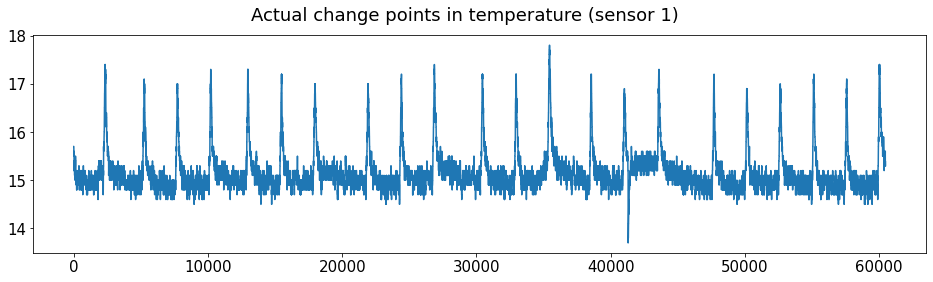

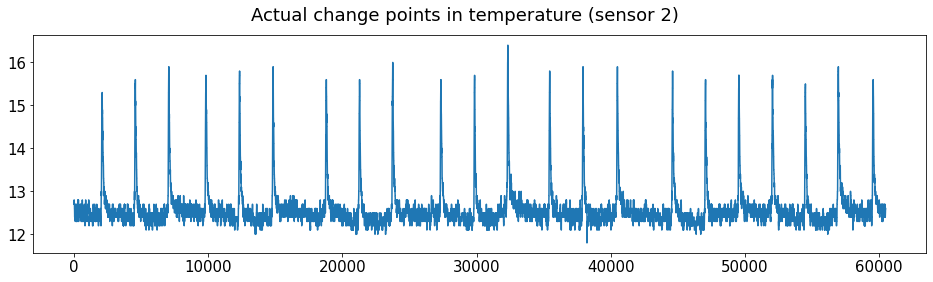

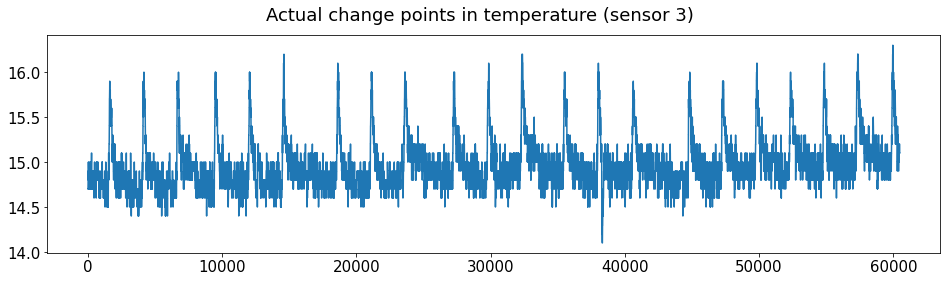

In [4]:
ts1 = []
tsA = Temperature_2_TOP
ts1 = np.append(ts1,tsA,axis=0)
plt.figure(figsize=(16,4))
plt.plot(ts1)
plt.suptitle('Actual change points in temperature (sensor 1)')

ts2 = []
tsB = Temperature_2_BOTTOM
ts2 = np.append(ts2,tsB,axis=0)   
plt.figure(figsize=(16,4))
plt.plot(ts2)
plt.suptitle('Actual change points in temperature (sensor 2)')

ts3 = []
tsC = Temperature_2_MIDDLE 
ts3 = np.append(ts3,tsC, axis=0)   
plt.figure(figsize=(16,4))
plt.plot(ts3)
plt.suptitle('Actual change points in temperature (sensor 3)')

In [34]:
ts1.size

60479

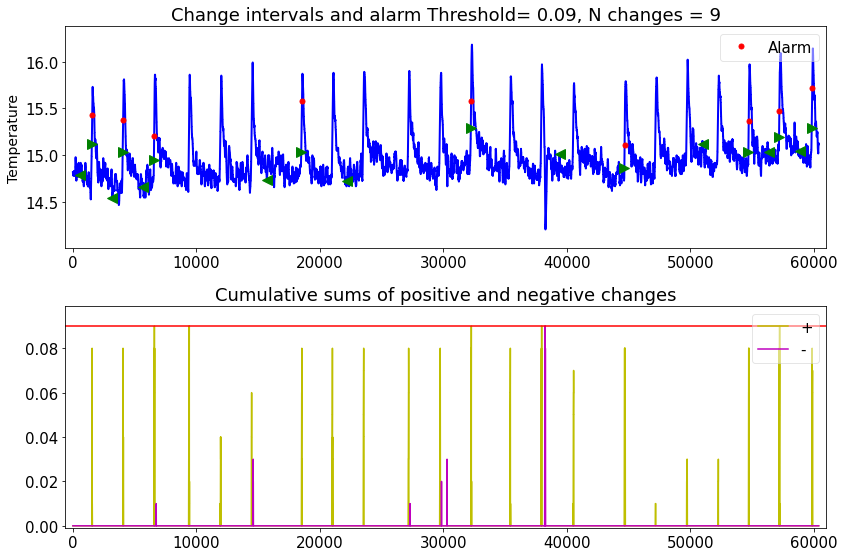

In [78]:
# Take the moving average samples and determine their cummulative cum
######################### Take every samples from 1 to 60 and return their average values ##############################
window_size = 60  
i = 0
moving_averages = []
while i < len(ts3) - window_size + 1:
    window = ts3[i : i + window_size]
    window_average = round(sum(window) / window_size, 2)
    moving_averages.append(window_average)
    i += 1

z = moving_averages 
data = pd.DataFrame(z)
data_1 = data.to_numpy()
x = data_1
########################################################################################################################
#################### CLASSICAL CUSUM STARTS HERE #######################################################################
def detect_cusum(x, threshold=0.09, drift=0.01, ending=False, show=True, ax=None):
    data = pd.DataFrame(z)
    data_1 = data.to_numpy()
    x = data_1
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
 ################## CLASSICAL CUSUM ALGORITHM ENDS HERE ##############################################################
    ############################ Estimation of when the change ends (offline form)###################################
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]
    
    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp
   #####################################################################################################################

def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function"""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10)
                     #label='Change started')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10)
                         #label='Change ended')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc= 'upper right', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        #ax1.set_xlabel('Samples', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Change intervals and alarm' +
                      ' Threshold= %.3g, N changes = %d'
                      % (threshold, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        #ax2.set_xlabel('Samples', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Temperature', fontsize=14)
        ax2.set_title('Cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='upper right', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()
        
ta, tai, taf, amp = detect_cusum(x, 0.09, 0.01, True, True)
####################################################################################################################

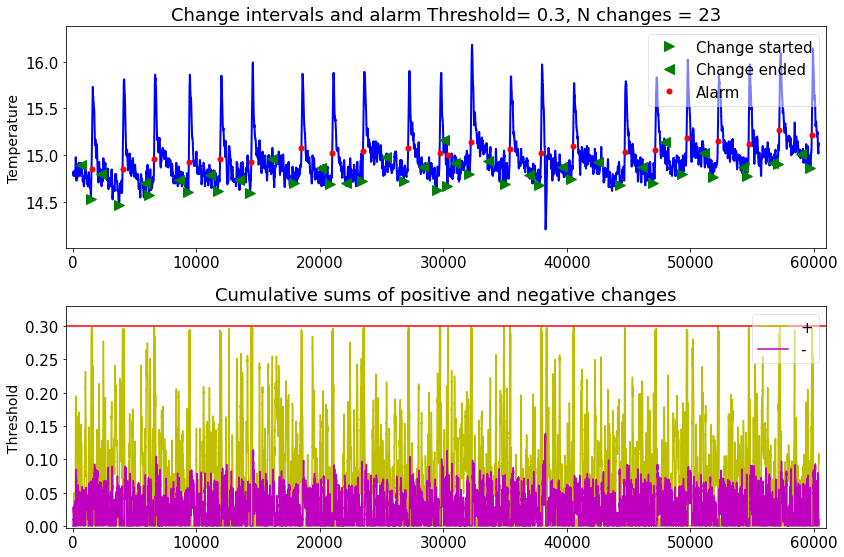

In [23]:
#Modified CUSUM 1
# Take the moving average samples and determine their cummulative cum
######################### Take every samples from 1 to 30 and return their average values ##############################
window_size = 60 
i = 0
moving_averages = []
while i < len(ts3) - window_size + 1:
    window = ts3[i : i + window_size]
    window_average = round(sum(window) / window_size, 2)
    moving_averages.append(window_average)
    i += 1

z = moving_averages 
data = pd.DataFrame(z)
data_1 = data.to_numpy()
x = data_1
########################################################################################################################
# threshold : positive number, optional (default = 1)
# drift : positive number, optional (default = 0).  Drift term that prevents any change in the absence of change
# amplitude: threshold for the change in the data
# ending : bool, optional (default = False) #True (1) to estimate when the change ends; False (0) otherwise
########################### ******RETURNS******* #######################################################################
# ta : 1D array_like [indi, indf], int, alarm time (index of when the change was detected)
# tai : 1D array_like, int, index of when the change started
# taf : 1D array_like, int, index of when the change ended (if `ending` is True)
# amp : 1D array_like, float, amplitude of changes (if `ending` is True)
def detect_cusum(x, threshold=0.3, drift=0.01, ending=False, show=True, ax=None):
    data = pd.DataFrame(z)
    data_1 = data.to_numpy()
    x = data_1
    gp, gn = np.zeros(x.size), np.zeros(x.size) # To hold +ve and -ve cummulative changes
    y = np.zeros(x.size) # To hold the sum of positive and negetive drifts
    e = np.zeros(x.size) # To hold error 
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    lamda = 0.01 # lambda is a weighted parameter; lamda(0) = 0
    learning_rate = 0.05 # Used as a tuning parameter
    ###################################### Modified function to detect change points ################################## 
    ######################################## Function to Find changes (online form) ###################################
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        #drift_plus = 0.01 + (gp[i-1]*gp[i-1])/50 # Modified drift correction # D+ = beta_1 + kappa*gpsquared (proposed in lit)
        #drift_minus = 0.01 + 50*(gn[i-1])        # Modified drift correction # D- = beta_2 - kappa*gpsquareroot
        
        drift_plus = lamda*gp[i-1]*gp[i-1]           # Modified drift correction # D+ = beta_1 + kappa*gpsquared
        drift_minus = (1-lamda)*gn[i-1]*gn[i-1]      # Modified drift correction # D- = beta_2 - kappa*gpsquareroot
        gp[i] = gp[i-1] + s - drift_plus    # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift_minus   # cumulative sum for - change
        y[i] = drift_plus + drift_minus    # drift error 
        e[i] = lamda*s - y[i]
        lamda = lamda + learning_rate*s*e[i]  # Adaptive drift correction 
      
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i    
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index 
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm   
     ###################################################################################################################
    ########################  Estimation of when the change ends (offline form) ########################################
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp
   #######################################################################################################################

##################################### PLOT ###############################################################################
def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Change started')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Change ended')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='upper right', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        #ax1.set_xlabel('Samples', fontsize=14)
        ax1.set_ylabel('Temperature', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Change intervals and alarm ' +
                      'Threshold= %.3g, N changes = %d'
                      % (threshold, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        #ax2.set_xlabel('Samples', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax2.set_ylabel('Threshold', fontsize=14)
        ax2.set_title('Cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='upper right', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()
 

ta, tai, taf, amp = detect_cusum(x, 0.3, 0.01, True, True)
#####################################################################################################################

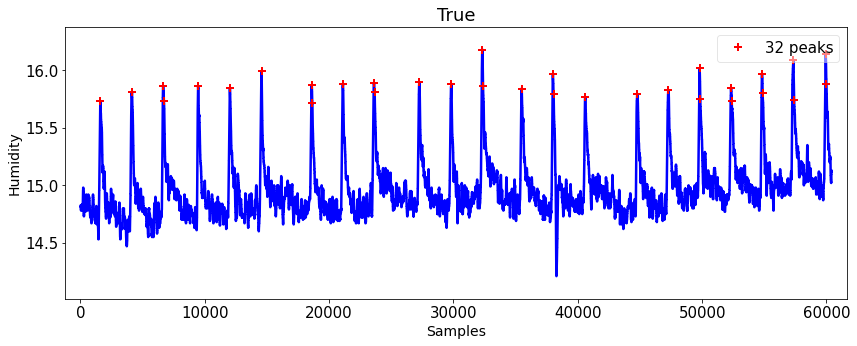

In [23]:
# Peak detection 
####################################################################################################################
window_size = 60
i = 0
moving_averages = []
while i < len(ts3) - window_size + 1:
    window = ts3[i : i + window_size]
    window_average = round(sum(window) / window_size, 2)  # Round off to two decimal places
    moving_averages.append(window_average)
    i += 1 

x = moving_averages 
####################################################################################################################
####################################################################################################################
#mph: detect peaks that are greater than minimum peak height or peaks that are smaller than maximum peak height
#mpd: detect peaks that are at least separated by minimum peak distance
#threshold : detect peaks (valleys) that are greater than `threshold` in relation to their immediate neighbors
#edge: {None, 'rising', 'falling', 'both'}, optional (default = 'rising') for a flat peak, keep only the rising edge ('rising'), only the falling edge ('falling'), both edges ('both'), or don't detect a flat peak (None)
#kpsh : bool, optional (default = False) keep peaks with same height even if they are closer than `mpd`
#valley : bool, optional (default = False) if True (1), detect valleys (local minima) instead of peaks
#####################################################################################################################
def detect_peaks(x, mph=15.7, mpd=50, threshold=0, edge1='descending',
                 kpsh=False, valley=False, show=False, ax=None, title=True):
 
    x = np.atleast_1d(moving_averages).astype('float64')
    if valley:
        x = -x
        if mph is not None:
            mph = -mph
    dx = x[1:] - x[:-1] # find indices of all peaks
    indnan = np.where(np.isnan(x))[0] # handle NaN's
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge1:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge1.lower() in ['ascending']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge1.lower() in ['descending']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    if ind.size and indnan.size:
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    if ind.size and ind[0] == 0: # first and last values of x cannot be peaks
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    if ind.size and mph is not None:  # remove peaks < minimum peak height
        ind = ind[x[ind] >= mph]
    if ind.size and threshold > 0:  # remove peaks - neighbors < threshold
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    if ind.size and mpd > 1:  # detect small peaks closer than minimum peak distance
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                       & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
            if mph is not None:
                mph = -mph
        _plot(x, mph, mpd, threshold, edge1, valley, ax, ind, title)

    return ind


def _plot(x, mph, mpd, threshold, edge1, valley, ax, ind, title):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(14, 5))
            no_ax = True
        else:
            no_ax = False

        ax.plot(x, 'b', lw=2.5)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='upper right', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        #ax.axhline(mph, color='r')
        ax.set_xlabel('Samples', fontsize=14)
        ax.set_ylabel('Humidity', fontsize=14)
        if title:
            if not isinstance(title, str):
                mode = 'Valley detection' if valley else 'Peak detection'
                #title = "%s (mph=%s, mpd=%d)"% \
                        #(mode, str(mph), mpd)
            ax.set_title(title)
        # plt.grid()
        if no_ax:
            plt.show()

ind = detect_peaks(x, show=True)

In [5]:
data=ts3
ret = []
cf = changefinder.ChangeFinder(r=0.01, order=5, smooth=5)

#Setting the forgetting factor
for i in data:
    score = cf.update(i)
    ret.append(score)

# Plot
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)
ax.plot(ret, 'r')
ax2 = ax.twinx()
ax2.plot(data,'b')
plt.show()

NameError: name 'changefinder' is not defined

In [47]:
ts_change_loc1 = pd.Series(ret).nlargest(200)
ts_change_loc1 = ts_change_loc1.index
ts_change_loc1

Int64Index([  42,   41,   33,   40,   44,   43,   53,   52,   56, 2780,
            ...
            4432,   71,   74,   70, 6390, 8242, 8041,   73, 5068,   72],
           dtype='int64', length=200)

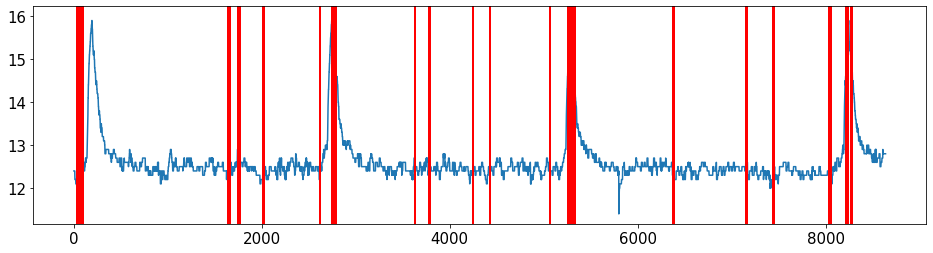

In [48]:
def plot_change_points(ts2,ts_change_loc1):
    plt.figure(figsize=(16,4))
    plt.plot(ts2)
    for x in ts_change_loc1:
        plt.axvline(x,lw=2, color='red')
            
plot_change_points(ts2,ts_change_loc1)

In [57]:
# Detect change point using PELT method
import ruptures as rpt

# Detect the change points
algo1 = rpt.Pelt(model="rbf").fit(ts1)
change_location1 = algo1.predict(pen=10)

# Point the change points:
def plot_change_points(ts1,ts_change_loc):
    plt.figure(figsize=(16,4))
    plt.plot(ts1)
    for x in ts_change_loc:
        plt.axvline(x,lw=2, color='red')

plot_change_points(ts1,change_location1)

KeyboardInterrupt: 

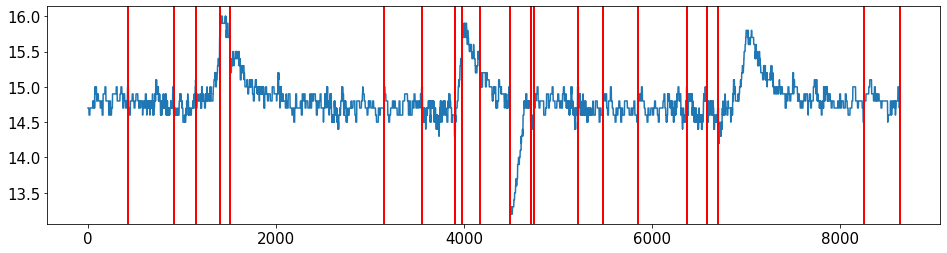

In [52]:
#Changepoint detection with window-based search method
algo3 = rpt.Window(width=20, model='l2').fit(ts3)
my_bkps = algo3.predict(n_bkps=20)

# show results
def plot_change_points(tsC,ts_change_loc):
    plt.figure(figsize=(16,4))
    plt.plot(ts3)
    for x in ts_change_loc:
        plt.axvline(x,lw=2, color='red')
               
plot_change_points(ts1,my_bkps)

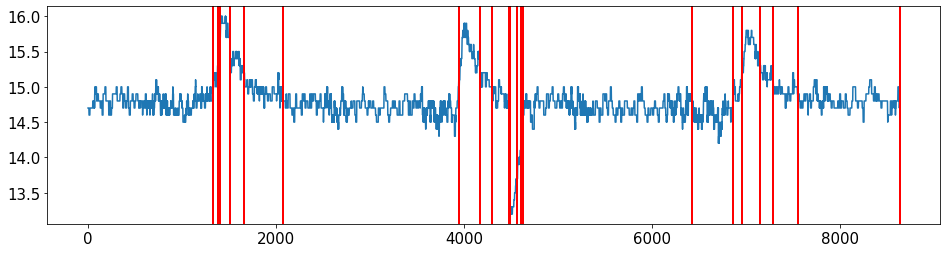

In [54]:
#Binary segmentation search
algo2 = rpt.Binseg(model='l2').fit(ts3)
my_bkps = algo2.predict(n_bkps=20)

# show results
def plot_change_points(tsC,ts_change_loc):
    plt.figure(figsize=(16,4))
    plt.plot(ts3)
    for x in ts_change_loc:
        plt.axvline(x,lw=2, color='red')
               
plot_change_points(ts3,my_bkps)

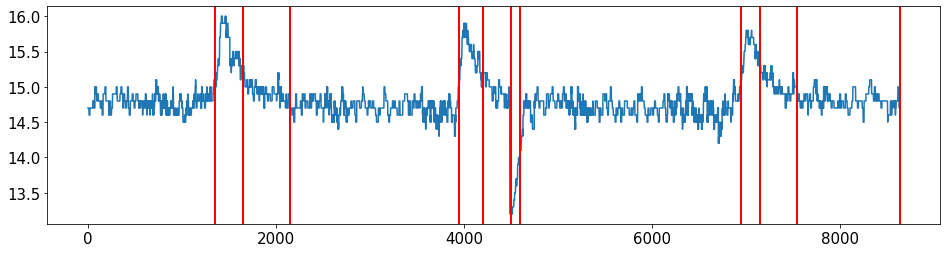

In [56]:
#Changepoint detection with dynamic programming search method
algo4 = rpt.Dynp(model='l1', min_size=30, jump=50).fit(ts3)
my_bkps = algo4.predict(n_bkps=10)

# show results
def plot_change_points(ts3,ts_change_loc):
    plt.figure(figsize=(16,4))
    plt.plot(ts3)
    for x in ts_change_loc:
        plt.axvline(x,lw=2, color='red')
               
plot_change_points(ts3,my_bkps)

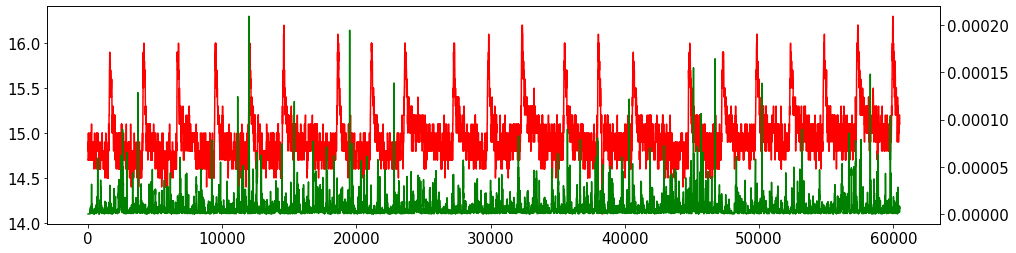

In [63]:
from fastsst import SingularSpectrumTransformation

#sst = SingularSpectrumTransformation(win_length=60)

# Lanczos
#score_L = SingularSpectrumTransformation(win_length=60, n_components=6, use_lanczos=True).score_offline(ts1)
#plot_data_and_score(x,score_L)

# SVD
score_S = SingularSpectrumTransformation(win_length=60, n_components=3, use_lanczos=False).score_offline(ts3)
#plot_data_and_score(x,score_S)  # doesn't match above change-point score!

"""
note:
 - data must be 1d np.ndarray
 - the first run takes a few seconds for jit compling
"""
#score = sst.score_offline(ts1)
#plt.plot(score)
#plt.plot(ts1)

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)
ax.plot(ts3, 'r')
ax2 = ax.twinx()
#plt.axhline(ax=14.8,lw=2, color='black')
#ax2.plot(score_L,'b')
ax2.plot(score_S, 'g')
plt.show()

In [21]:
ts_change_loc1 = pd.Series(score_S).nlargest(25)
ts_change_loc1 = ts_change_loc1.index
ts_change_loc1

Int64Index([11994, 19495, 11995, 11996, 46721, 46720, 46722, 11997, 46723,
            19494, 46719, 45115, 45116, 11998, 46724, 58289, 11999, 58288,
            45114, 46718, 58290, 12000, 22803, 45117, 50216],
           dtype='int64')

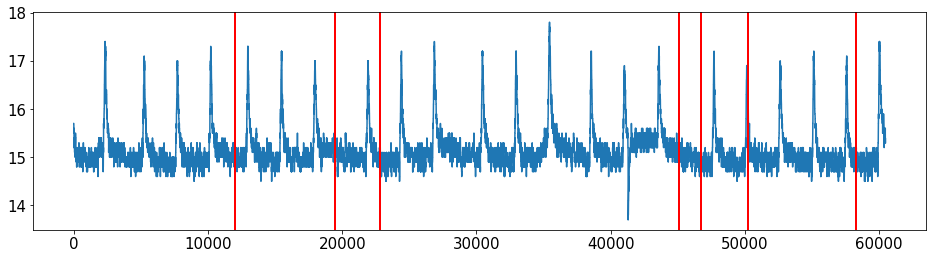

In [22]:
def plot_change_points(ts1,ts_change_loc1):
    plt.figure(figsize=(16,4))
    plt.plot(ts1)
    for x in ts_change_loc1:
        plt.axvline(x,lw=2, color='red')
            
plot_change_points(ts1,ts_change_loc1)

Change has been detected in data: 81.0 - of index: 877
Change has been detected in data: 81.1 - of index: 1516
Change has been detected in data: 81.3 - of index: 1553
Change has been detected in data: 80.6 - of index: 4032
Change has been detected in data: 80.9 - of index: 4064
Change has been detected in data: 80.4 - of index: 6575
Change has been detected in data: 80.6 - of index: 6605
Change has been detected in data: 80.5 - of index: 9386
Change has been detected in data: 80.6 - of index: 9417
Change has been detected in data: 80.9 - of index: 11930
Change has been detected in data: 80.7 - of index: 11962
Change has been detected in data: 80.7 - of index: 14465
Change has been detected in data: 80.3 - of index: 14496
Change has been detected in data: 80.7 - of index: 16304
Change has been detected in data: 80.8 - of index: 18486
Change has been detected in data: 81.2 - of index: 18520
Change has been detected in data: 80.9 - of index: 21002
Change has been detected in data: 80.7 - 

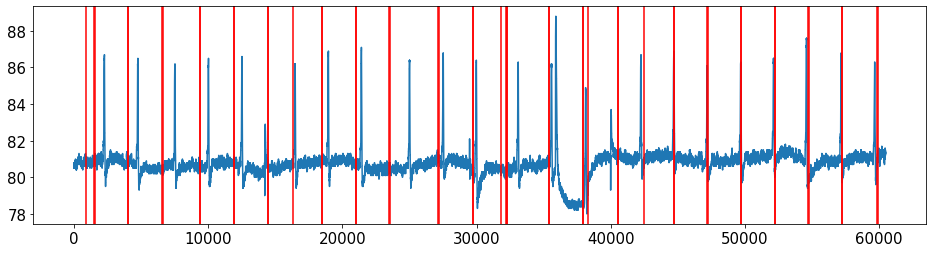

In [34]:
from skmultiflow.drift_detection import PageHinkley
plt.rcParams['figure.figsize'] = [16, 4]
ph = PageHinkley()
plt.plot(ts1)

for i in range(len(ts3)):
    ph.add_element(ts3[i])
    if ph.detected_change():
        print('Change has been detected in data: ' + str(ts1[i]) + ' - of index: ' + str(i))
        plt.axvline(x=i,color='r')
        
plt.show()

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skmultiflow.drift_detection.hddm_a import HDDM_A
from skmultiflow.drift_detection.hddm_w import HDDM_W
# plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [18, 8]

Change has been detected in data: 15.1 - of index: 1907
Change has been detected in data: 15.7 - of index: 2241
Change has been detected in data: 16.7 - of index: 2293
Change has been detected in data: 15.9 - of index: 5175
Change has been detected in data: 16.7 - of index: 5230
Change has been detected in data: 15.4 - of index: 7622
Change has been detected in data: 16.2 - of index: 7675
Change has been detected in data: 15.4 - of index: 10121
Change has been detected in data: 16.5 - of index: 10164
Change has been detected in data: 16.1 - of index: 12899
Change has been detected in data: 17.1 - of index: 12958
Change has been detected in data: 15.7 - of index: 15391
Change has been detected in data: 16.6 - of index: 15445
Change has been detected in data: 15.2 - of index: 16624
Change has been detected in data: 16.0 - of index: 17910
Change has been detected in data: 16.9 - of index: 17974
Change has been detected in data: 15.3 - of index: 20283
Change has been detected in data: 15.4

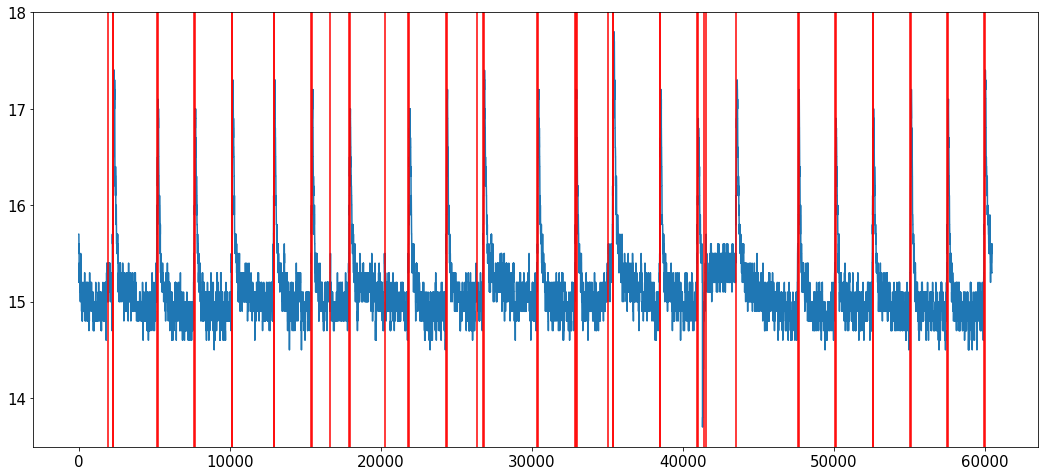

Warning zone has been detected in data: 15.2 - of index: 1858
Warning zone has been detected in data: 15.3 - of index: 1859
Warning zone has been detected in data: 15.3 - of index: 1860
Warning zone has been detected in data: 15.4 - of index: 1861
Warning zone has been detected in data: 15.3 - of index: 1862
Warning zone has been detected in data: 15.3 - of index: 1863
Warning zone has been detected in data: 15.3 - of index: 1864
Change has been detected in data: 15.4 - of index: 1865
Warning zone has been detected in data: 15.6 - of index: 2233
Warning zone has been detected in data: 15.7 - of index: 2234
Warning zone has been detected in data: 15.6 - of index: 2235
Warning zone has been detected in data: 15.7 - of index: 2236
Change has been detected in data: 15.6 - of index: 2237
Warning zone has been detected in data: 16.9 - of index: 2301
Warning zone has been detected in data: 16.9 - of index: 2302
Warning zone has been detected in data: 16.9 - of index: 2303
Change has been dete

Warning zone has been detected in data: 15.4 - of index: 17868
Warning zone has been detected in data: 15.3 - of index: 17869
Warning zone has been detected in data: 15.3 - of index: 17870
Warning zone has been detected in data: 15.4 - of index: 17871
Warning zone has been detected in data: 15.4 - of index: 17872
Change has been detected in data: 15.4 - of index: 17873
Warning zone has been detected in data: 16.5 - of index: 17939
Warning zone has been detected in data: 16.5 - of index: 17940
Warning zone has been detected in data: 16.6 - of index: 17941
Warning zone has been detected in data: 16.6 - of index: 17942
Change has been detected in data: 16.6 - of index: 17943
Warning zone has been detected in data: 15.4 - of index: 18616
Warning zone has been detected in data: 15.4 - of index: 18617
Warning zone has been detected in data: 15.4 - of index: 18618
Warning zone has been detected in data: 15.4 - of index: 18619
Warning zone has been detected in data: 15.4 - of index: 18620
Warn

Warning zone has been detected in data: 15.3 - of index: 29244
Warning zone has been detected in data: 15.3 - of index: 29245
Warning zone has been detected in data: 15.3 - of index: 29246
Warning zone has been detected in data: 15.3 - of index: 29247
Warning zone has been detected in data: 15.3 - of index: 29248
Warning zone has been detected in data: 15.1 - of index: 29249
Warning zone has been detected in data: 15.1 - of index: 29250
Warning zone has been detected in data: 15.1 - of index: 29251
Warning zone has been detected in data: 15.4 - of index: 29810
Warning zone has been detected in data: 15.5 - of index: 29811
Warning zone has been detected in data: 15.5 - of index: 29812
Warning zone has been detected in data: 15.5 - of index: 29813
Change has been detected in data: 15.5 - of index: 29814
Warning zone has been detected in data: 15.4 - of index: 30335
Warning zone has been detected in data: 15.4 - of index: 30336
Warning zone has been detected in data: 15.4 - of index: 3033

Warning zone has been detected in data: 15.3 - of index: 41562
Warning zone has been detected in data: 15.3 - of index: 41563
Warning zone has been detected in data: 15.3 - of index: 41564
Warning zone has been detected in data: 15.3 - of index: 41565
Warning zone has been detected in data: 15.5 - of index: 41587
Warning zone has been detected in data: 15.4 - of index: 41588
Warning zone has been detected in data: 15.3 - of index: 41589
Warning zone has been detected in data: 15.4 - of index: 41663
Warning zone has been detected in data: 15.4 - of index: 41664
Warning zone has been detected in data: 15.4 - of index: 41665
Warning zone has been detected in data: 15.3 - of index: 41666
Warning zone has been detected in data: 15.4 - of index: 41667
Warning zone has been detected in data: 15.4 - of index: 41668
Warning zone has been detected in data: 15.6 - of index: 41844
Warning zone has been detected in data: 15.6 - of index: 41845
Warning zone has been detected in data: 15.6 - of index

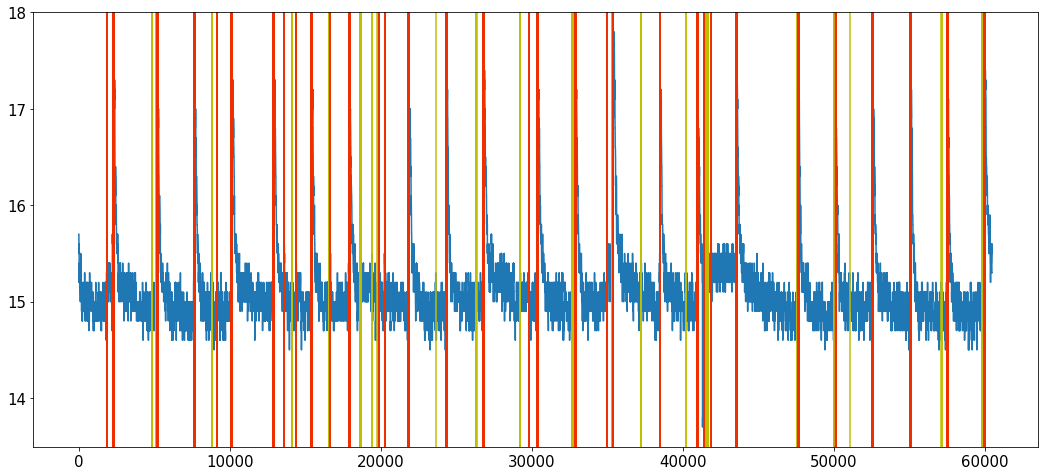

In [37]:
hddm_a = HDDM_A()
plt.plot(ts1)
for i in range(len(ts1)):
  hddm_a.add_element(ts1[i])
  #if hddm_a.detected_warning_zone():
      #print('Warning zone has been detected in data: ' + str(ts1[i]) + ' - of index: ' + str(i))
      #plt.axvline(x = i,color='y')
  if hddm_a.detected_change():
      print('Change has been detected in data: ' + str(ts1[i]) + ' - of index: ' + str(i))
      plt.axvline(x = i,color='r')
plt.show()

hddm_w = HDDM_W()
plt.plot(ts1)
for i in range(len(ts1)):
  hddm_w.add_element(ts1[i])
  if hddm_w.detected_warning_zone():
      print('Warning zone has been detected in data: ' + str(ts1[i]) + ' - of index: ' + str(i))
      plt.axvline(x = i,color='y')
  if hddm_w.detected_change():
      print('Change has been detected in data: ' + str(ts1[i]) + ' - of index: ' + str(i))
      plt.axvline(x = i,color='r')
plt.show()

In [7]:
!pip install roerich

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\ABC\\.conda\\envs\\tensor\\Lib\\site-packages\\~~ipy\\.libs\\libansari.R6EA3HQP5KZ6TAXU4Y4ZVTRPT7UVA53Z.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.




  Using cached roerich-0.4.0-py3-none-any.whl
  Using cached matplotlib-3.6.0-cp38-cp38-win_amd64.whl (7.2 MB)
  Using cached torch-1.12.1-cp38-cp38-win_amd64.whl (161.9 MB)
  Using cached scipy-1.9.1-cp38-cp38-win_amd64.whl (38.6 MB)
  Using cached pandas-1.5.0-cp38-cp38-win_amd64.whl (11.0 MB)
  Using cached torchvision-0.13.1-cp38-cp38-win_amd64.whl (1.1 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached torchaudio-0.12.1-cp38-cp38-win_amd64.whl (969 kB)
  Using cached scikit_learn-1.1.2-cp38-cp38-win_amd64.whl (7.3 MB)
  Using cached fonttools-4.37.4-py3-none-any.whl (960 kB)
  Using cached contourpy-1.0.5-cp38-cp38-win_amd64.whl (164 kB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [22]:
!pip install -U scikit-multiflow

In [7]:
pip install peakutils

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install fastsst

  Created wheel for fastsst: filename=fastsst-0.0.4-py3-none-any.whl size=7086 sha256=406852a017e3718b6d6fd12919ba5720fa74f5c64d186c5f611978342df19447
  Stored in directory: c:\users\abc\appdata\local\pip\cache\wheels\69\8e\30\f347d8493122539a54cb954bf31d1389cbfac386a9b2c8106a
Successfully built fastsst
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install bocd

  Created wheel for bocd: filename=bocd-0.1.2-py3-none-any.whl size=5344 sha256=4e4f33c030f1c09a7c692fcd81255b819d625544065eb986ea8fde8546f5d4f5
  Stored in directory: c:\users\abc\appdata\local\pip\cache\wheels\21\78\3f\2d054624a715b0b22ccba14dd41ca5059decb489fc91df190b
Successfully built bocd
Note: you may need to restart the kernel to use updated packages.


In [176]:
pip install bayesian-changepoint-detection

  Created wheel for bayesian-changepoint-detection: filename=bayesian_changepoint_detection-0.2.dev1-py3-none-any.whl size=6157 sha256=3084b13724888ce79bc95efeb1d32f1aca365e8567c3c4268d8a6f5c827bbad0
  Stored in directory: c:\users\abc\appdata\local\pip\cache\wheels\17\b1\05\5c93cdb87d944c0c2770edb04e5f5279101fe7b4ccdb42175f
Successfully built bayesian-changepoint-detection
Note: you may need to restart the kernel to use updated packages.


In [92]:
pip install padasip

  Created wheel for padasip: filename=padasip-1.2.2-py3-none-any.whl size=51665 sha256=c553b44487430fb29dbdd5e8019ec6a646f153f2c50d7c0e7297a4ef3694a78a
  Stored in directory: c:\users\abc\appdata\local\pip\cache\wheels\8a\89\44\d82169c9a1caecb223315bcb714dc329497f7f10a4761560eb
Successfully built padasip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from detecta import detect_cusum

In [3]:
pip install changefinder

  Using cached changefinder-0.3-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install ruptures

Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install detecta

Note: you may need to restart the kernel to use updated packages.


In [10]:
from detecta import detect_peaks

In [3]:
pip install hana-ml

  Using cached hana_ml-2.14.22091801-py3-none-any.whl (6.6 MB)
  Using cached schedule-1.1.0-py2.py3-none-any.whl (10 kB)
  Using cached Deprecated-1.2.13-py2.py3-none-any.whl (9.6 kB)
  Using cached htmlmin-0.1.12.tar.gz (19 kB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=8db7026ff55f5706d28e7662fffc73e02dde23d1758c1e7c7f71db425045014a
  Stored in directory: c:\users\abc\appdata\local\pip\cache\wheels\23\14\6e\4be5bfeeb027f4939a01764b48edd5996acf574b0913fe5243
Successfully built htmlmin
Note: you may need to restart the kernel to use updated packages.


In [15]:
import statistics

In [36]:
#Modified CUSUM 1
# Take the moving average samples and determine their cummulative cum
######################### Take every samples from 1 to 30 and return their average values ##############################
window_size = 60 
variance = []
covaraince = []
i = 0
moving_averages = []
while i < len(ts3) - window_size + 1:
    window = ts3[i : i + window_size]
    window_average = round(sum(window) / window_size, 2)
    moving_averages.append(window_average)
    #window_deviations = [(ts3[i]-window_average)**2 for ts3[i] in ts3] 
    #window_variance = sum(window_deviations)/window_size
    #variance.append((window_variance)
    output = statistics.variance(window)
    variance.append(output)
    i += 1

z = moving_averages 
data = pd.DataFrame(z)
data_1 = data.to_numpy()
x = data_1

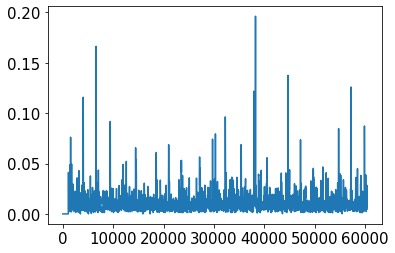

In [37]:
plt.plot(variance)

Change has been detected in data: 15.5 - of index: 1677
Change has been detected in data: 16.0 - of index: 4163
Change has been detected in data: 15.9 - of index: 6693
Change has been detected in data: 15.7 - of index: 9528
Change has been detected in data: 15.9 - of index: 12073
Change has been detected in data: 16.1 - of index: 14597
Change has been detected in data: 15.8 - of index: 18642
Change has been detected in data: 15.8 - of index: 21140
Change has been detected in data: 15.8 - of index: 23643
Change has been detected in data: 16.0 - of index: 27308
Change has been detected in data: 16.0 - of index: 29862
Change has been detected in data: 16.2 - of index: 32343
Change has been detected in data: 15.7 - of index: 38062
Change has been detected in data: 15.6 - of index: 40693
Change has been detected in data: 16.0 - of index: 44834
Change has been detected in data: 15.9 - of index: 47340
Change has been detected in data: 16.1 - of index: 49850
Change has been detected in data: 1

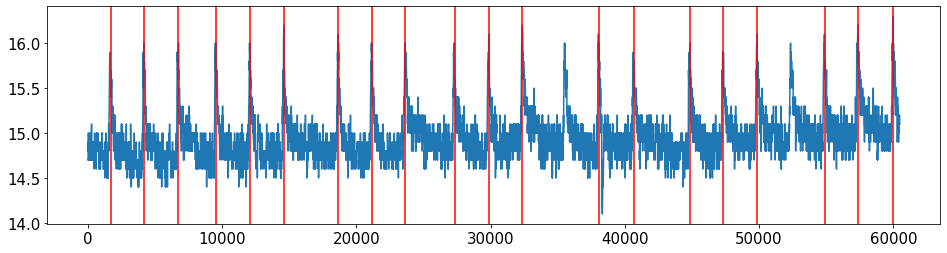

In [15]:
from skmultiflow.drift_detection.base_drift_detector import BaseDriftDetector


class PageHinkley(BaseDriftDetector):
    """ Page-Hinkley method for concept drift detection.
    Notes
    -----
    This change detection method works by computing the observed 
    values and their mean up to the current moment. Page-Hinkley
    won't output warning zone warnings, only change detections. 
    The method works by means of the Page-Hinkley test [1]_. In general
    lines it will detect a concept drift if the observed mean at 
    some instant is greater then a threshold value lambda.
    References
    ----------
    .. [1] E. S. Page. 1954. Continuous Inspection Schemes.
       Biometrika 41, 1/2 (1954), 100–115.
    
    Parameters
    ----------
    min_instances: int (default=30)
        The minimum number of instances before detecting change.
    delta: float (default=0.005)
        The delta factor for the Page Hinkley test.
    threshold: int (default=50)
        The change detection threshold (lambda).
    alpha: float (default=1 - 0.0001)
        The forgetting factor, used to weight the observed value 
        and the mean.
    
    Examples
    --------
    >>> # Imports
    >>> import numpy as np
    >>> from skmultiflow.drift_detection import PageHinkley
    >>> ph = PageHinkley()
    >>> # Simulating a data stream as a normal distribution of 1's and 0's
    >>> data_stream = np.random.randint(2, size=2000)
    >>> # Changing the data concept from index 999 to 2000
    >>> for i in range(999, 2000):
    ...     data_stream[i] = np.random.randint(4, high=8)
    >>> # Adding stream elements to the PageHinkley drift detector and verifying if drift occurred
    >>> for i in range(2000):
    ...     ph.add_element(data_stream[i])
    ...     if ph.detected_change():
    ...         print('Change has been detected in data: ' + str(data_stream[i]) + ' - of index: ' + str(i))
    
    """
    def __init__(self, min_instances=30, delta=0.5, threshold=30, alpha=1 - 0.0001):
        super().__init__()
        self.min_instances = min_instances
        self.delta = delta
        self.threshold = threshold
        self.alpha = alpha
        self.x_mean = None
        self.sample_count = None
        self.sum = None
        self.reset()

    def reset(self):
        """ reset
        Resets the change detector parameters.
        """
        super().reset()
        self.sample_count = 1
        self.x_mean = 0.0
        self.sum = 0.0

    def add_element(self, x):
        """ Add a new element to the statistics
        
        Parameters
        ----------
        x: numeric value
            The observed value, from which we want to detect the
            concept change.
        
        Notes
        -----
        After calling this method, to verify if change was detected, one 
        should call the super method detected_change, which returns True 
        if concept drift was detected and False otherwise.
        
        """
        if self.in_concept_change:
            self.reset()

        self.x_mean = self.x_mean + (x - self.x_mean) / float(self.sample_count)
        self.sum = max(0., self.alpha * self.sum + (x - self.x_mean - self.delta))

        self.sample_count += 1

        self.estimation = self.x_mean
        self.in_concept_change = False
        self.in_warning_zone = False

        self.delay = 0

        if self.sample_count < self.min_instances:
            return None

        if self.sum > self.threshold:
            self.in_concept_change = True
    
    
ph = PageHinkley()
fig = plt.figure(figsize=(16,4))
plt.plot(ts3)


for i in range(len(ts3)):
    ph.add_element(ts3[i])
    if ph.detected_change():
        plt.axvline(x=i,color='r')
        print('Change has been detected in data: ' + str(ts3[i]) + ' - of index: ' + str(i))
        
plt.show()